<a href="https://colab.research.google.com/github/mostafaganjuri/mostafaganjuri/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript. Old versions: [v1.0](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.0-alpha/AlphaFold2.ipynb), [v1.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.1-premultimer/AlphaFold2.ipynb), [v1.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.2.0/AlphaFold2.ipynb), [v1.3](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.3.0/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold - Making protein folding accessible to all.
*bioRxiv*, 2021](https://www.biorxiv.org/content/10.1101/2021.08.15.456425v2) 

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os.path
import re
import hashlib
import random

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'SGVFQLQLQEFINERGVLASGRPCEPGCRTFFRVCLKHFQAVVSPGPCTFGTVSTPVLGTNSFAVRDDSSGGGRNPLQLPFNFTWPGTFSLIIEAWHAPGDDLRPEALPPDALISKIAIQGSLAVGQNWLLDEQTSTLTRLRYSYRVICSDNYYGDNCSRLCKKRNDHFGHYVCQPDGNLSCLPGWTGEYCggsEAAAKEAAAK EAAAK EAAAK sgg ADDQN PWRAYLDLLFPTDTLLLDLLW' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = 'DLL4-Phlip,var3' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
use_amber = True #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (mmCIF format)

if template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False


In [2]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
pair_mode = "unpaired+paired" #@param ["unpaired+paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if msa_mode.startswith("MMseqs2"):
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [3]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
num_recycles = 6 #@param [1,3,6,12,24,48] {type:"raw"}
#@markdown  - "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

You are logged into Google Drive and are good to go!


In [4]:
#@title Install dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install --no-warn-conflicts -q "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"
  pip install --upgrade "jax[cuda]<0.3.0" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  wget -qnc https://raw.githubusercontent.com/deepmind/alphafold/main/docker/openmm.patch
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  touch AMBER_READY
fi

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.2+cuda11.cudnn805
    Uninstalling jaxlib-0.3.2+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.2+cuda11.cudnn805


2022-05-03 19:42:56,062 Running colabfold 1.3.0 (09ea4385c9f23279f2d695828199309ff4b2322b)
2022-05-03 19:42:56,065 Found 6 citations for tools or databases
2022-05-03 19:43:02,440 Query 1/1: DLL4Phlipvar3_73e45 (length 243)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


2022-05-03 19:43:04,970 Running model_1
2022-05-03 19:52:44,710 model_1 took 570.0s (6 recycles) with pLDDT 87


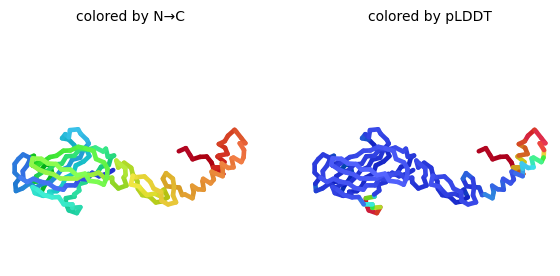

2022-05-03 19:56:24,381 Running model_2
2022-05-03 20:02:18,104 model_2 took 346.8s (6 recycles) with pLDDT 85.6


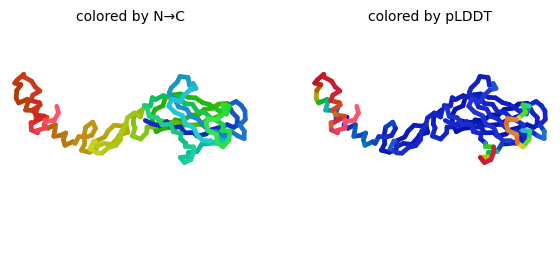

2022-05-03 20:05:55,207 Running model_3
2022-05-03 20:11:48,822 model_3 took 346.9s (6 recycles) with pLDDT 87.9


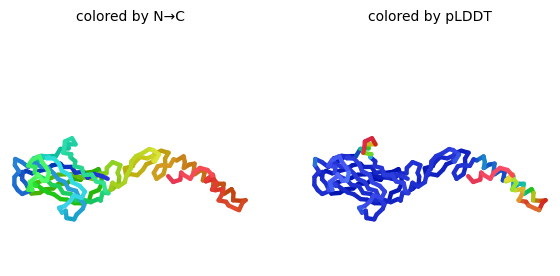

2022-05-03 20:15:33,380 Running model_4
2022-05-03 20:21:26,638 model_4 took 346.6s (6 recycles) with pLDDT 86


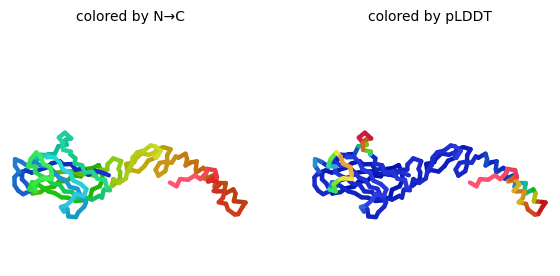

2022-05-03 20:25:12,662 Running model_5
2022-05-03 20:31:06,264 model_5 took 346.9s (6 recycles) with pLDDT 85.6


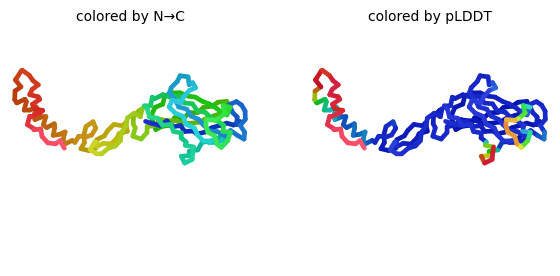

2022-05-03 20:34:39,404 reranking models by plddt
2022-05-03 20:34:41,992 Done


In [5]:
#@title Run Prediction

import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=100)
  plt.show()
  plt.close()

result_dir="."
setup_logging(Path(".").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    use_amber=use_amber,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
)

In [6]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}

jobname_prefix = ".custom" if msa_mode == "custom" else ""
if use_amber:
  pdb_filename = f"{jobname}{jobname_prefix}_relaxed_rank_{rank_num}_model_*.pdb"
else:
  pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_rank_{rank_num}_model_*.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()




You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


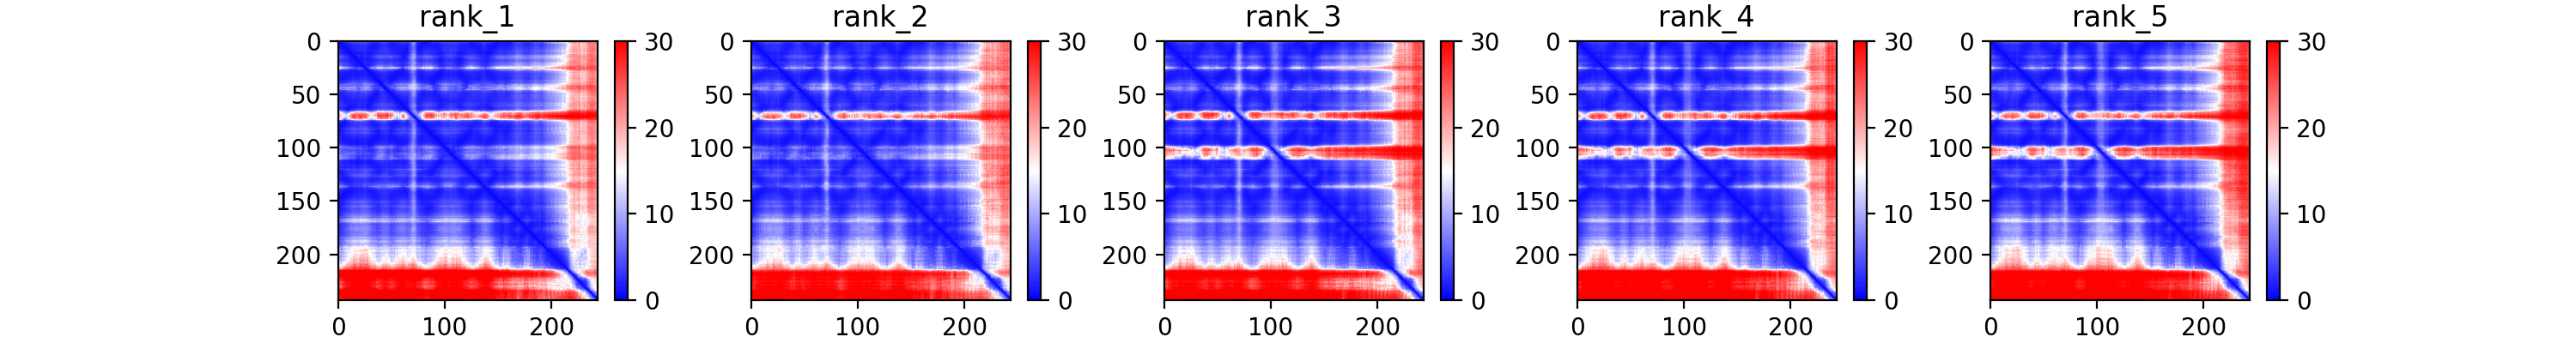
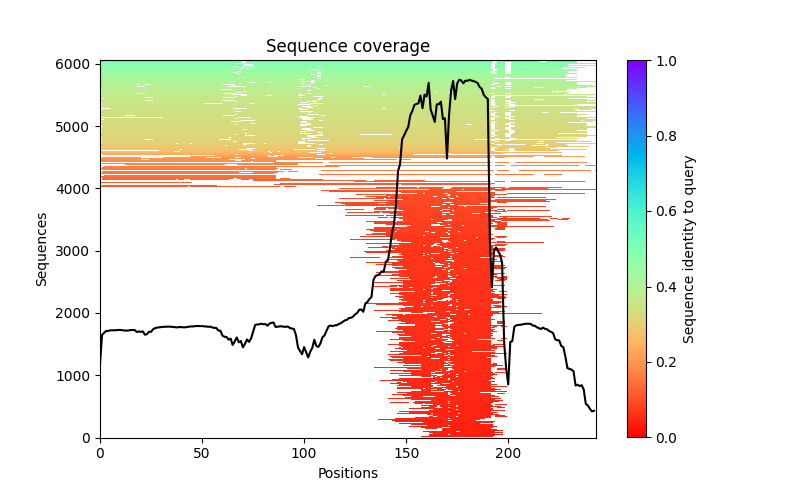
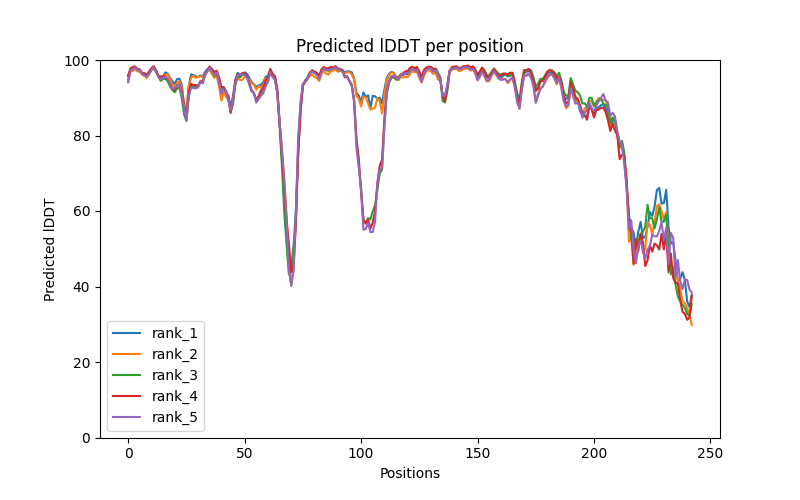

In [7]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"{jobname}{jobname_prefix}_PAE.png")
cov = image_to_data_url(f"{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [8]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" config.json $jobname*".json" $jobname*".a3m" $jobname*"relaxed_rank_"*".pdb" "cite.bibtex" $jobname*".png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

  adding: config.json (deflated 48%)
  adding: DLL4Phlipvar3_73e45_predicted_aligned_error_v1.json (deflated 90%)
  adding: DLL4Phlipvar3_73e45_unrelaxed_rank_1_model_3_scores.json (deflated 70%)
  adding: DLL4Phlipvar3_73e45_unrelaxed_rank_2_model_1_scores.json (deflated 70%)
  adding: DLL4Phlipvar3_73e45_unrelaxed_rank_3_model_4_scores.json (deflated 70%)
  adding: DLL4Phlipvar3_73e45_unrelaxed_rank_4_model_5_scores.json (deflated 70%)
  adding: DLL4Phlipvar3_73e45_unrelaxed_rank_5_model_2_scores.json (deflated 70%)
  adding: DLL4Phlipvar3_73e45.a3m (deflated 75%)
  adding: DLL4Phlipvar3_73e45_relaxed_rank_1_model_3.pdb (deflated 78%)
  adding: DLL4Phlipvar3_73e45_relaxed_rank_2_model_1.pdb (deflated 78%)
  adding: DLL4Phlipvar3_73e45_relaxed_rank_3_model_4.pdb (deflated 78%)
  adding: DLL4Phlipvar3_73e45_relaxed_rank_4_model_5.pdb (deflated 78%)
  adding: DLL4Phlipvar3_73e45_relaxed_rank_5_model_2.pdb (deflated 78%)
  adding: DLL4Phlipvar3_73e45_unrelaxed_rank_1_model_3.pdb (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-05-03 20:34:43,080 file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7

# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running steps is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the averagge pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomical identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomical identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**Using custom templates**

To predict the structure with a custom templates (mmCIF formatted): (1) change the `template_mode` to "custom" execture cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible). Templates need to be in mmCIF format, its names must follow the PDB naming (four letters) and must contain `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date`. To convert a PDB file into a ColabFold compatible mmCIF see this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparision to the full AlphaFold2 and Alphafold2 colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparision against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [preprint](https://www.biorxiv.org/content/10.1101/2021.08.15.456425v1). 

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software. 

- [Söding Lab](https://www.mpibpc.mpg.de/soeding) for providing the computational resources for the MMseqs2 server

- Richard Evans for helping to bechmark the ColabFold's Alphafold-multimer support

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
